In [202]:
import sqlite3
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat
from math import ceil
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from pandas_profiling import ProfileReport
%matplotlib inline
sns.set()

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [201]:
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# Reading the Data

In [203]:
df, meta = pyreadstat.read_sas7bdat('a2z_insurance.sas7bdat')

In [204]:
df.head()

,CustID,FirstPolYear,BirthYear,EducDeg,MonthSal,GeoLivArea,Children,CustMonVal,ClaimsRate,PremMotor,PremHousehold,PremHealth,PremLife,PremWork
0,1.0,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45


# Make a copy of  original dataset

In [205]:
df_original = df.copy()

In [206]:
# Change The Column Namr
df.rename(columns={'CustID': 'ID', 'FirstPolYear': 'First Policy', 'BirthYear':'Birthday', 'EducDeg':'Education','MonthSal':'Salary','GeoLivArea':'Area','CustMonVal':'CMV', 'ClaimsRate':'Claims', 'PremMotor': 'Motor', 'PremHousehold':'Household','PremHealth': 'Health', 'PremLife':'Life', 'PremWork':'Work Compensation'  }, inplace=True)
df

,ID,First Policy,Birthday,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
0,1.0,1985.0,1982.0,2 - High School,2177.0,1.0,1.0,380.97,0.39,375.85,79.45,146.36,47.01,16.89
1,2.0,1981.0,1995.0,2 - High School,677.0,4.0,1.0,-131.13,1.12,77.46,416.20,116.69,194.48,106.13
2,3.0,1991.0,1970.0,1 - Basic,2277.0,3.0,0.0,504.67,0.28,206.15,224.50,124.58,86.35,99.02
3,4.0,1990.0,1981.0,3 - BSc/MSc,1099.0,4.0,1.0,-16.99,0.99,182.48,43.35,311.17,35.34,28.34
4,5.0,1986.0,1973.0,3 - BSc/MSc,1763.0,4.0,1.0,35.23,0.90,338.62,47.80,182.59,18.78,41.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10291,10292.0,1984.0,1949.0,4 - PhD,3188.0,2.0,0.0,-0.11,0.96,393.74,49.45,173.81,9.78,14.78
10292,10293.0,1977.0,1952.0,1 - Basic,2431.0,3.0,0.0,1405.60,0.00,133.58,1035.75,143.25,12.89,105.13
10293,10294.0,1994.0,1976.0,3 - BSc/MSc,2918.0,1.0,1.0,524.10,0.21,403.63,132.80,142.25,12.67,4.89
10294,10295.0,1981.0,1977.0,1 - Basic,1971.0,2.0,1.0,250.05,0.65,188.59,211.15,198.37,63.90,112.91


In [207]:
# replace "" by nans
df.replace("", np.nan, inplace=True)

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10296 entries, 0 to 10295
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 10296 non-null  float64
 1   First Policy       10266 non-null  float64
 2   Birthday           10279 non-null  float64
 3   Education          10279 non-null  object 
 4   Salary             10260 non-null  float64
 5   Area               10295 non-null  float64
 6   Children           10275 non-null  float64
 7   CMV                10296 non-null  float64
 8   Claims             10296 non-null  float64
 9   Motor              10262 non-null  float64
 10  Household          10296 non-null  float64
 11  Health             10253 non-null  float64
 12  Life               10192 non-null  float64
 13  Work Compensation  10210 non-null  float64
dtypes: float64(13), object(1)
memory usage: 1.1+ MB


In [209]:
df.dtypes

ID                   float64
First Policy         float64
Birthday             float64
Education             object
Salary               float64
Area                 float64
Children             float64
CMV                  float64
Claims               float64
Motor                float64
Household            float64
Health               float64
Life                 float64
Work Compensation    float64
dtype: object

In [210]:
# Check for duplicated observations
df.duplicated().sum()

0

In [211]:
# Get the basic descriptive statistics on for the numeric variables
df.describe().T # .T for cleaner visualization

,count,mean,std,min,25%,50%,75%,max
ID,10296.0,5148.500000,2972.343520,1.00,2574.75,5148.50,7722.2500,10296.00
First Policy,10266.0,1991.062634,511.267913,1974.00,1980.00,1986.00,1992.0000,53784.00
Birthday,10279.0,1968.007783,19.709476,1028.00,1953.00,1968.00,1983.0000,2001.00
Salary,10260.0,2506.667057,1157.449634,333.00,1706.00,2501.50,3290.2500,55215.00
Area,10295.0,2.709859,1.266291,1.00,1.00,3.00,4.0000,4.00
Children,10275.0,0.706764,0.455268,0.00,0.00,1.00,1.0000,1.00
CMV,10296.0,177.892605,1945.811505,-165680.42,-9.44,186.87,399.7775,11875.89
Claims,10296.0,0.742772,2.916964,0.00,0.39,0.72,0.9800,256.20
Motor,10262.0,300.470252,211.914997,-4.11,190.59,298.61,408.3000,11604.42
Household,10296.0,210.431192,352.595984,-75.00,49.45,132.80,290.0500,25048.80


In [212]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,10296,NaN,NaN,NaN,5148.5,2972.34,1,2574.75,5148.5,7722.25,10296
First Policy,10266,NaN,NaN,NaN,1991.06,511.268,1974,1980,1986,1992,53784
Birthday,10279,NaN,NaN,NaN,1968.01,19.7095,1028,1953,1968,1983,2001
Education,10279,4,3 - BSc/MSc,4799,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Salary,10260,NaN,NaN,NaN,2506.67,1157.45,333,1706,2501.5,3290.25,55215
Area,10295,NaN,NaN,NaN,2.70986,1.26629,1,1,3,4,4
Children,10275,NaN,NaN,NaN,0.706764,0.455268,0,0,1,1,1
CMV,10296,NaN,NaN,NaN,177.893,1945.81,-165680,-9.44,186.87,399.778,11875.9
Claims,10296,NaN,NaN,NaN,0.742772,2.91696,0,0.39,0.72,0.98,256.2
Motor,10262,NaN,NaN,NaN,300.47,211.915,-4.11,190.59,298.61,408.3,11604.4


In [213]:
# descriptive statistics for the categorical variables
df.describe(include =['O']).T

,count,unique,top,freq
Education,10279,4,3 - BSc/MSc,4799


In [214]:
print("Checking Memory Use Each Columns");print()
df.memory_usage(deep=True)/1024**2

Checking Memory Use Each Columns



Index                0.000122
ID                   0.078552
First Policy         0.078552
Birthday             0.078552
Education            0.675411
Salary               0.078552
Area                 0.078552
Children             0.078552
CMV                  0.078552
Claims               0.078552
Motor                0.078552
Household            0.078552
Health               0.078552
Life                 0.078552
Work Compensation    0.078552
dtype: float64

# Define Metric and Categorical Features' Names

In [215]:
# Define metric and non-metric features. Why?
non_metric_features = ["Education"]
metric_features = df.columns.drop(non_metric_features).to_list()

# Fill missing values (Data imputation)

In [216]:
# Creating a copy to apply central tendency measures imputation
df_central = df.copy()

In [217]:
# count of missing values
df_central.isna().sum()

ID                     0
First Policy          30
Birthday              17
Education             17
Salary                36
Area                   1
Children              21
CMV                    0
Claims                 0
Motor                 34
Household              0
Health                43
Life                 104
Work Compensation     86
dtype: int64

In [218]:
df_central.median()

ID                   5148.50
First Policy         1986.00
Birthday             1968.00
Salary               2501.50
Area                    3.00
Children                1.00
CMV                   186.87
Claims                  0.72
Motor                 298.61
Household             132.80
Health                162.81
Life                   25.56
Work Compensation      25.67
dtype: float64

In [219]:
modes = df_central[non_metric_features].mode().loc[0]
modes

Education    3 - BSc/MSc
Name: 0, dtype: object

In [220]:
df_central.fillna(df_central.median(), inplace=True)
df_central.fillna(modes, inplace=True)
df_central.isna().sum()

ID                   0
First Policy         0
Birthday             0
Education            0
Salary               0
Area                 0
Children             0
CMV                  0
Claims               0
Motor                0
Household            0
Health               0
Life                 0
Work Compensation    0
dtype: int64

In [221]:
# Creating new df copy to explore neighbordhood imputation
df_neighbors = df.copy()

In [222]:
# Seeing rows with NaNs
nans_index = df_neighbors.isna().any(axis=1)
df_neighbors[nans_index]

,ID,First Policy,Birthday,Education,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
21,22.0,1977.0,1958.0,2 - High School,NaN,3.0,1.0,111.37,0.80,407.52,111.70,100.13,24.67,30.34
68,69.0,1983.0,1977.0,2 - High School,1399.0,4.0,1.0,476.65,0.33,330.73,186.70,211.15,NaN,15.78
138,139.0,1979.0,1976.0,2 - High School,2538.0,2.0,1.0,149.59,0.69,194.26,305.60,NaN,37.34,17.67
143,144.0,1996.0,1990.0,3 - BSc/MSc,NaN,4.0,1.0,-42.45,1.02,146.36,353.95,220.04,121.80,42.01
184,185.0,1993.0,1984.0,2 - High School,2419.0,4.0,1.0,-62.23,1.07,NaN,253.95,230.60,5.89,43.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,10011.0,NaN,1947.0,2 - High School,3959.0,2.0,NaN,-128.24,1.14,177.81,153.35,311.28,67.79,35.45
10057,10058.0,1983.0,1980.0,2 - High School,1569.0,4.0,1.0,222.60,0.55,235.60,211.15,NaN,32.34,68.79
10142,10143.0,1986.0,1985.0,3 - BSc/MSc,1652.0,3.0,1.0,55.67,0.88,257.05,94.45,308.39,NaN,13.78
10284,10285.0,1980.0,1987.0,3 - BSc/MSc,1504.0,4.0,1.0,-1.55,0.96,390.63,29.45,179.70,-6.00,NaN


In [223]:
# KNNImputer - only works for numerical varaibles
imputer = KNNImputer(n_neighbors=5, weights="uniform")
df_neighbors[metric_features] = imputer.fit_transform(df_neighbors[metric_features])

In [224]:
# See rows with NaNs imputed
df_neighbors.loc[nans_index, metric_features]

,ID,First Policy,Birthday,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
21,22.0,1977.0,1958.0,3125.0,3.0,1.0,111.37,0.80,407.520,111.70,100.130,24.670,30.340
68,69.0,1983.0,1977.0,1399.0,4.0,1.0,476.65,0.33,330.730,186.70,211.150,22.516,15.780
138,139.0,1979.0,1976.0,2538.0,2.0,1.0,149.59,0.69,194.260,305.60,204.994,37.340,17.670
143,144.0,1996.0,1990.0,2435.2,4.0,1.0,-42.45,1.02,146.360,353.95,220.040,121.800,42.010
184,185.0,1993.0,1984.0,2419.0,4.0,1.0,-62.23,1.07,275.652,253.95,230.600,5.890,43.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,10011.0,1988.8,1947.0,3959.0,2.0,0.2,-128.24,1.14,177.810,153.35,311.280,67.790,35.450
10057,10058.0,1983.0,1980.0,1569.0,4.0,1.0,222.60,0.55,235.600,211.15,235.466,32.340,68.790
10142,10143.0,1986.0,1985.0,1652.0,3.0,1.0,55.67,0.88,257.050,94.45,308.390,24.916,13.780
10284,10285.0,1980.0,1987.0,1504.0,4.0,1.0,-1.55,0.96,390.630,29.45,179.700,-6.000,20.626


# Histograms of Metric Features

title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manually, not adjusting
title position was updated manu

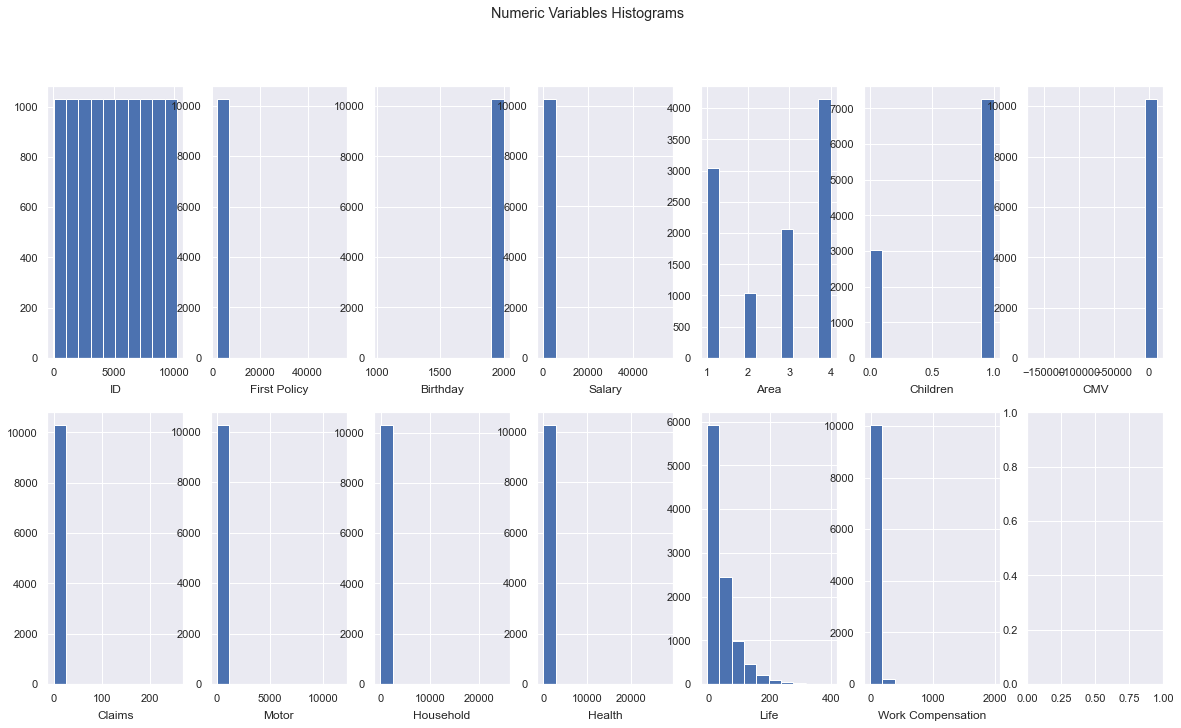

In [225]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df[feat], bins = 10)
    ax.set_title(feat, y = -0.15)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Histograms"

plt.suptitle(title)

plt.show()

# Boxplot of Metric Features

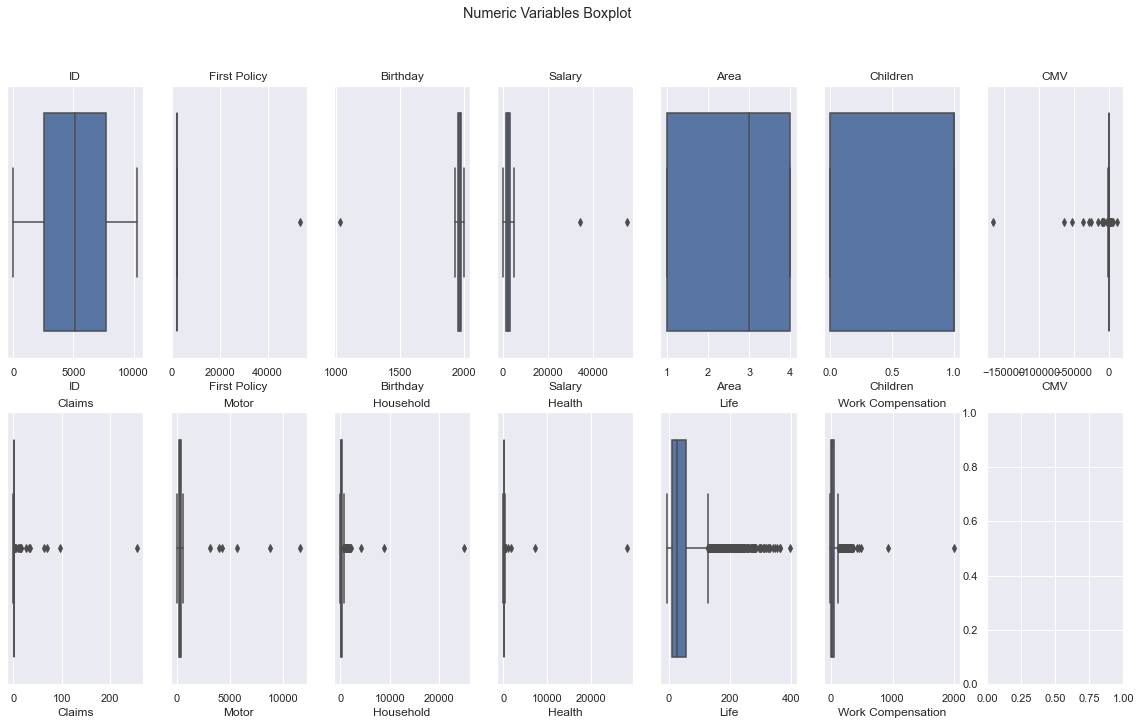

In [226]:
# All Numeric Variables' Histograms in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(df[feat], ax = ax)
    ax.set_title(feat)
    
# Layout
# Add a centered title to the figure:
title = "Numeric Variables Boxplot"

plt.suptitle(title)

plt.show()

# Barplots of Categorical Features

In [227]:
df['Education'].value_counts()

3 - BSc/MSc        4799
2 - High School    3510
1 - Basic          1272
4 - PhD             698
Name: Education, dtype: int64

title position was updated manually, not adjusting
top of axes not in the figure, so title not moved
title position was updated manually, not adjusting
top of axes not in the figure, so title not moved
title position was updated manually, not adjusting
top of axes not in the figure, so title not moved
title position was updated manually, not adjusting


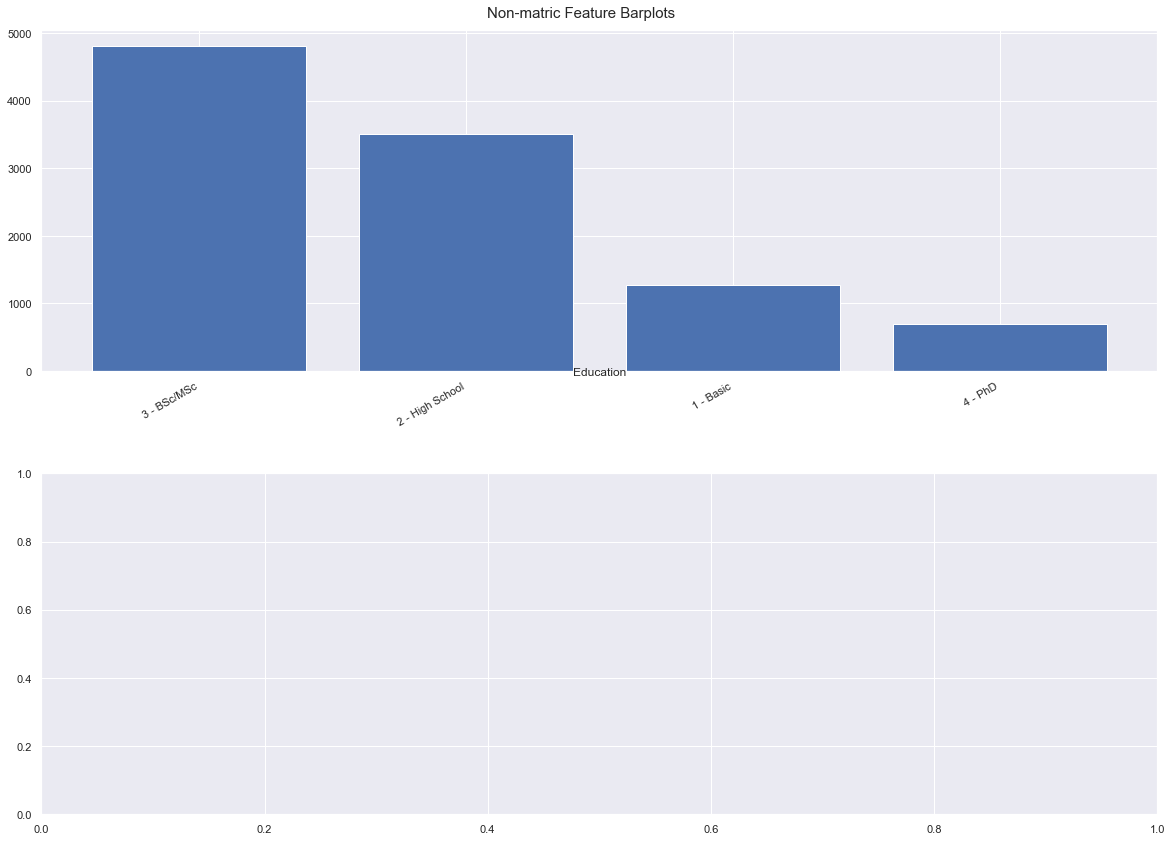

In [228]:
# All Non-numeric Variables' Barplots in one figure
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))


# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    ax.bar(df[feat].value_counts().index,df[feat].value_counts().values)
    ax.set_title(feat, y=-0.03)
    #labels rotation
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    
# Layout
# Add a centered title to the figure:
title = "Non-matric Feature Barplots"
plt.suptitle(title, y=1.03, fontsize=15)
# Space in betweeen rows
plt.subplots_adjust(top = 1.00, bottom=0.01, hspace=0.3,)

plt.show();

In [229]:
# let's keep the central imputation
df = df_central.copy()

# Outlier removal

In [230]:
# This may vary from session to session, and is prone to varying interpretations.
# A simple example is provided below:

filters1 = (
    (df['Salary']<=6000)
    &
    (df['CMV']<=1000)
    &
    (df['Claims']<=30)
    &
    (df['Motor']<=1200)
    &
    (df['Household']<=900)
    &
    (df['Health']<=900)
    &
    (df['Life']<=350)
        
)

df_1 = df[filters1]

In [231]:
print('Percentage of data kept after removing outliers:', np.round(df_1.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9745


In [232]:
print('The proportion of records excluded is', np.round(1-((df_1.shape[0] / df_original.shape[0])), 4))

The proportion of records excluded is 0.0255


# Outlier removal using only the IQR method

In [233]:
q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters2.append(df[metric].between(llim, ulim, inclusive=True))

filters2 = pd.Series(np.all(filters2, 0))
df_2 = df[filters2]
print('Percentage of data kept after removing outliers:', np.round(df_2.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.8538


# Combining different outlier methods

In [234]:
df_3 = df[(filters1 | filters2)]
print('Percentage of data kept after removing outliers:', np.round(df_3.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers: 0.9746


In [235]:
# Get the manual filtering version
df = df_3.copy()

# Feature Engineering

In [237]:
df['age'] = df['Birthday']
df['Birthday'] = datetime.now().year - df['age']
df['age']

0        39.0
1        26.0
2        51.0
3        40.0
4        48.0
         ... 
10290    22.0
10291    72.0
10293    45.0
10294    44.0
10295    40.0
Name: age, Length: 10034, dtype: float64

# Correlations Matricx

In [238]:
def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.1')
    plt.show()

In [239]:
cor_spearman = df_3.corr(method ='spearman')
cor_spearman

,ID,First Policy,Birthday,Salary,Area,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
ID,1.000000,-0.013717,0.014508,-0.017246,-0.006161,0.000399,-0.008432,0.015033,-0.014764,0.015981,0.001926,0.010785,0.016938
First Policy,-0.013717,1.000000,-0.016311,0.019848,-0.004155,-0.011883,0.012982,-0.010979,-0.017478,0.012280,0.009622,0.011403,0.015234
Birthday,0.014508,-0.016311,1.000000,-0.927563,-0.014392,0.507124,0.018907,0.003640,-0.183758,0.130403,-0.010882,0.139687,0.151023
Salary,-0.017246,0.019848,-0.927563,1.000000,0.011123,-0.475095,-0.014783,-0.004503,0.167488,-0.117958,0.006665,-0.123591,-0.135551
Area,-0.006161,-0.004155,-0.014392,0.011123,1.000000,-0.024118,-0.006784,0.008823,-0.006478,0.010862,0.005332,0.010949,0.010570
Children,0.000399,-0.011883,0.507124,-0.475095,-0.024118,1.000000,0.011492,-0.032834,0.266164,-0.144077,-0.275710,-0.163938,-0.131639
CMV,-0.008432,0.012982,0.018907,-0.014783,-0.006784,0.011492,1.000000,-0.972093,0.004287,0.187827,-0.076052,-0.001677,0.011308
Claims,0.015033,-0.010979,0.003640,-0.004503,0.008823,-0.032834,-0.972093,1.000000,-0.105334,-0.037549,0.116872,0.072210,0.061370
Motor,-0.014764,-0.017478,-0.183758,0.167488,-0.006478,0.266164,0.004287,-0.105334,1.000000,-0.649935,-0.692431,-0.698471,-0.678929
Household,0.015981,0.012280,0.130403,-0.117958,0.010862,-0.144077,0.187827,-0.037549,-0.649935,1.000000,0.270733,0.463708,0.453788


locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001AA6E8E2580>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x000001AA6E8E2580> on colorbar
Setting pcolormesh
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved
top of axes not in the figure, so title not moved


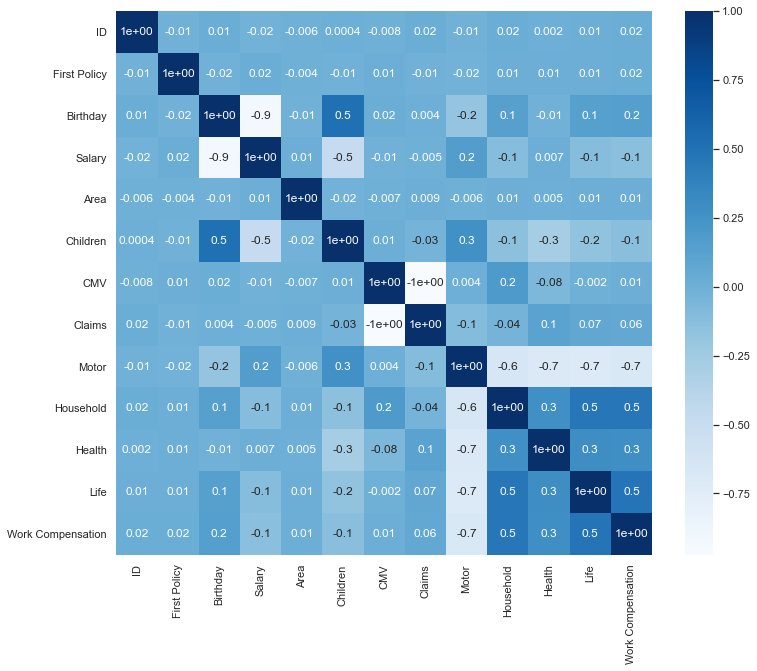

In [240]:
# DO IT
cor_heatmap(cor_spearman)

# Variable selection: Redundancy VS Relevancy

In [241]:
# Select variables according to their correlations
df.drop(columns=['Birthday', 'ID', 'First Policy','Area'], inplace=True)

In [242]:
# Updating metric_features
metric_features.remove('Birthday')
metric_features.remove('ID')
metric_features.remove('First Policy')
metric_features.remove('Area')

# Data Normalization

In [143]:
df_minmax = df.copy()

In [144]:
# Use MinMaxScaler to scale the data
scaler = MinMaxScaler()
scaled_feat = scaler.fit_transform(df_minmax[metric_features])
scaled_feat

array([[0.39334471, 1.        , 0.9603842 , ..., 0.33366294, 0.15282965,
        0.06232606],
       [0.07337884, 1.        , 0.92780314, ..., 0.26698429, 0.57011885,
        0.25484866],
       [0.41467577, 0.        , 0.9682543 , ..., 0.28471582, 0.26414827,
        0.23950985],
       ...,
       [0.55140785, 1.        , 0.96949049, ..., 0.32442637, 0.05565931,
        0.03643777],
       [0.34940273, 1.        , 0.95205475, ..., 0.45054723, 0.20062252,
        0.26947555],
       [0.52943686, 1.        , 0.96565087, ..., 0.32217902, 0.0393039 ,
        0.05369663]])

In [145]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.data_min_, "\n", scaler.data_max_)

Parameters fitted:
 [ 3.330000e+02  0.000000e+00 -1.471408e+04  0.000000e+00 -4.110000e+00
 -7.500000e+01 -2.110000e+00 -7.000000e+00 -1.200000e+01] 
 [5.02100e+03 1.00000e+00 1.00364e+03 2.53600e+01 5.85220e+02 8.99050e+02
 4.42860e+02 3.46400e+02 4.51530e+02]


In [146]:
df_minmax[metric_features] = scaled_feat
df_minmax.head()

,Education,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age
0,2 - High School,0.393345,1.0,0.960384,0.015379,0.644732,0.158565,0.333663,0.152830,0.062326,1982.0
1,2 - High School,0.073379,1.0,0.927803,0.044164,0.138411,0.504286,0.266984,0.570119,0.254849,1995.0
2,1 - Basic,0.414676,0.0,0.968254,0.011041,0.356778,0.307479,0.284716,0.264148,0.239510,1970.0
3,3 - BSc/MSc,0.163396,1.0,0.935065,0.039038,0.316614,0.121503,0.704047,0.119808,0.087028,1981.0
4,3 - BSc/MSc,0.305034,1.0,0.938387,0.035489,0.581559,0.126072,0.415084,0.072949,0.115311,1973.0


In [147]:
# Checking max and min of minmaxed variables
df_minmax[metric_features].describe().round(2)

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
count,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00
mean,0.47,0.71,0.95,0.03,0.52,0.27,0.38,0.13,0.11
std,0.21,0.45,0.02,0.02,0.23,0.20,0.17,0.13,0.10
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.00,0.94,0.02,0.35,0.13,0.26,0.05,0.05
50%,0.47,1.00,0.95,0.03,0.52,0.21,0.37,0.09,0.08
75%,0.63,1.00,0.96,0.04,0.70,0.36,0.50,0.18,0.14
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [148]:
df_standard = df.copy()

In [149]:
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(df_standard[metric_features])
scaled_feat

array([[-0.35816621,  0.6414439 ,  0.51495829, ..., -0.30342227,
         0.14062536, -0.50287617],
       [-1.90586526,  0.6414439 , -0.9637638 , ..., -0.70311682,
         3.35959354,  1.46660032],
       [-0.25498627, -1.55898279,  0.87215009, ..., -0.59682797,
         0.99933702,  1.30968663],
       ...,
       [ 0.40639712,  0.6414439 ,  0.92825548, ..., -0.35878946,
        -0.60894654, -0.7677094 ],
       [-0.57071688,  0.6414439 ,  0.13691827, ...,  0.39722192,
         0.50929948,  1.6162311 ],
       [ 0.30012179,  0.6414439 ,  0.75399093, ..., -0.3722608 ,
        -0.73511211, -0.59115391]])

In [150]:
# See what the fit method is doing (notice the trailing underscore):
print("Parameters fitted:\n", scaler.mean_, "\n", scaler.var_)

Parameters fitted:
 [2.52412777e+03 7.08491130e-01 2.02633488e+02 6.92763604e-01
 3.02300043e+02 1.86185041e+02 1.68883547e+02 4.05675563e+01
 3.96760903e+01] 
 [9.39311163e+05 2.06531449e-01 1.19932373e+05 2.47815733e-01
 1.82030278e+04 3.76866965e+04 5.51034325e+03 2.09881419e+03
 2.05313507e+03]


In [151]:
df_standard[metric_features] = scaled_feat
df_standard.head()

,Education,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age
0,2 - High School,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0
1,2 - High School,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0
2,1 - Basic,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0
3,3 - BSc/MSc,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0
4,3 - BSc/MSc,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0


In [152]:
# Checking mean and variance of standardized variables
df_standard[metric_features].describe().round(2)

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation
count,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00,10034.00
mean,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.26,-1.56,-43.07,-1.39,-2.27,-1.35,-2.30,-1.04,-1.14
25%,-0.79,-1.56,-0.61,-0.59,-0.75,-0.71,-0.75,-0.67,-0.64
50%,-0.00,0.64,-0.05,0.05,0.01,-0.30,-0.07,-0.33,-0.31
75%,0.80,0.64,0.55,0.58,0.79,0.45,0.69,0.33,0.32
max,2.58,0.64,2.31,49.55,2.10,3.67,3.69,6.68,9.09


In [153]:
df = df_standard.copy()

# One-hot encoding

In [154]:
df_ohc = df.copy()

In [155]:
# Use OneHotEncoder to encode the categorical features. Get feature names and create a DataFrame 
# with the one-hot encoded categorical features (pass feature names)
ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df.head(15)

C:\Users\foazu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0
5,0.0,1.0,0.0,0.0
6,0.0,1.0,0.0,0.0
7,0.0,1.0,0.0,0.0
8,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0


In [156]:
# Reassigning df to contain ohc variables
df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD
0,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0,0.0,1.0,0.0,0.0
1,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0,0.0,1.0,0.0,0.0
2,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0,1.0,0.0,0.0,0.0
3,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0,0.0,0.0,1.0,0.0
4,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0,0.0,0.0,1.0,0.0


In [157]:
df = df_ohc.copy()

# Dimensionality Reduction: PCA

In [158]:
df_pca = df.copy()

# A more specific explanation of PCA

In [159]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat  # What is this output?

array([[-8.58819080e-01, -7.87878604e-01,  6.06630304e-01, ...,
        -1.09420264e-01,  1.52353004e-02, -8.36246538e-02],
       [ 3.48436671e+00,  8.47873461e-01,  2.60360753e+00, ...,
         1.80695669e-03, -1.97996243e-01,  3.81424242e-02],
       [ 1.51890713e+00, -1.25113545e+00, -5.25793965e-01, ...,
         9.04131488e-01,  4.34910804e-03,  1.64594615e-01],
       ...,
       [-1.43505495e+00, -1.31375726e+00, -3.51202186e-02, ...,
        -4.30912294e-01,  6.62632481e-03, -5.00777871e-03],
       [ 1.52598261e+00, -2.21241566e-01,  8.93055789e-01, ...,
        -4.30483650e-01,  4.21612691e-02, -9.33086541e-02],
       [-1.52614645e+00, -1.09368521e+00,  6.49067231e-02, ...,
        -3.38801123e-01, -7.18211520e-03, -3.19521813e-02]])

In [160]:
pca_feat.shape

(10034, 9)

In [161]:
len(metric_features)

9

In [162]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
)

,Eigenvalue,Difference,Proportion,Cumulative
1,2.924770,0.000000,0.324942,0.324942
2,1.997866,-0.926905,0.221963,0.546905
3,1.569298,-0.428567,0.174349,0.721254
4,0.904956,-0.664342,0.100541,0.821795
5,0.594283,-0.310673,0.066025,0.887820
6,0.573335,-0.020948,0.063698,0.951517
7,0.404292,-0.169044,0.044917,0.996434
8,0.021955,-0.382336,0.002439,0.998873
9,0.010141,-0.011814,0.001127,1.000000


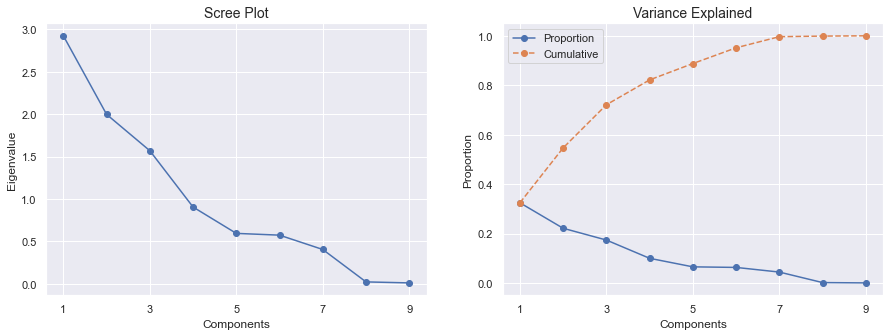

In [163]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [164]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=5)
pca_feat = pca.fit_transform(df_pca[metric_features])
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df.head(10)

,PC0,PC1,PC2,PC3,PC4
0,-0.858819,-0.787879,0.606630,-0.228414,-0.293450
1,3.484367,0.847873,2.603608,1.377429,-0.933332
2,1.518907,-1.251135,-0.525794,1.264809,0.550912
3,0.785296,1.074083,0.717595,-2.385903,0.072725
4,-0.546414,0.669573,0.865091,-0.707944,0.447345
5,-1.858168,0.902093,0.547912,0.068747,0.003356
6,1.141062,1.370859,-2.735384,-0.901578,-0.062391
7,1.006787,1.050899,1.342325,0.395995,-0.468570
8,-0.964860,-0.643726,0.388824,-1.394934,0.106964
9,1.018411,1.540773,-2.192003,-0.182842,0.346194


In [165]:
# Reassigning df to contain pca variables
df_pca = pd.concat([df_pca, pca_df], axis=1)
df_pca.head()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD,PC0,PC1,PC2,PC3,PC4
0,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0,0.0,1.0,0.0,0.0,-0.858819,-0.787879,0.606630,-0.228414,-0.293450
1,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0,0.0,1.0,0.0,0.0,3.484367,0.847873,2.603608,1.377429,-0.933332
2,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0,1.0,0.0,0.0,0.0,1.518907,-1.251135,-0.525794,1.264809,0.550912
3,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0,0.0,0.0,1.0,0.0,0.785296,1.074083,0.717595,-2.385903,0.072725
4,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0,0.0,0.0,1.0,0.0,-0.546414,0.669573,0.865091,-0.707944,0.447345


# How do we interpret each Principal Component (with style)?

In [166]:
df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]

,PC0,PC1,PC2,PC3,PC4
Salary,-0.258789,0.073780,-0.810346,0.282933,0.023763
Children,-0.268342,-0.064240,0.818320,-0.236506,-0.005440
CMV,0.016900,-0.988388,-0.095716,-0.051510,0.000230
Claims,0.089595,0.975815,0.104552,0.080352,-0.038767
Motor,-0.975861,-0.019936,0.083794,0.159169,-0.015171
Household,0.720365,-0.182213,0.070188,0.186681,-0.254920
Health,0.529525,0.154315,-0.392178,-0.730981,0.015306
Life,0.723286,-0.020634,0.156833,0.301434,-0.375253
Work Compensation,0.708813,-0.033652,0.179984,0.272744,0.621179


In [167]:
def _color_red_or_green(val):
    if val < -0.45:
        color = 'background-color: red'
    elif val > 0.45:
        color = 'background-color: green'
    else:
        color = ''
    return color

# Interpreting each Principal Component
loadings = df_pca[metric_features + pca_feat_names].corr().loc[metric_features, pca_feat_names]
loadings.style.applymap(_color_red_or_green)

,PC0,PC1,PC2,PC3,PC4
Salary,-0.258789,0.073780,-0.810346,0.282933,0.023763
Children,-0.268342,-0.064240,0.818320,-0.236506,-0.005440
CMV,0.016900,-0.988388,-0.095716,-0.051510,0.000230
Claims,0.089595,0.975815,0.104552,0.080352,-0.038767
Motor,-0.975861,-0.019936,0.083794,0.159169,-0.015171
Household,0.720365,-0.182213,0.070188,0.186681,-0.254920
Health,0.529525,0.154315,-0.392178,-0.730981,0.015306
Life,0.723286,-0.020634,0.156833,0.301434,-0.375253
Work Compensation,0.708813,-0.033652,0.179984,0.272744,0.621179


# Import preprocessed data

In [168]:
df_preprocessed = df_pca.copy()
df_preprocessed.head(10)

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD,PC0,PC1,PC2,PC3,PC4
0,-0.358166,0.641444,0.514958,-0.608190,0.545143,-0.549810,-0.303422,0.140625,-0.502876,1982.0,0.0,1.0,0.0,0.0,-0.858819,-0.787879,0.606630,-0.228414,-0.293450
1,-1.905865,0.641444,-0.963764,0.858230,-1.666487,1.184846,-0.703117,3.359594,1.466600,1995.0,0.0,1.0,0.0,0.0,3.484367,0.847873,2.603608,1.377429,-0.933332
2,-0.254986,-1.558983,0.872150,-0.829157,-0.712652,0.197367,-0.596828,0.999337,1.309687,1970.0,1.0,0.0,0.0,0.0,1.518907,-1.251135,-0.525794,1.264809,0.550912
3,-1.470446,0.641444,-0.634177,0.597087,-0.888091,-0.735768,1.916789,-0.114107,-0.250181,1981.0,0.0,0.0,1.0,0.0,0.785296,1.074083,0.717595,-2.385903,0.072725
4,-0.785331,0.641444,-0.483388,0.416295,0.269199,-0.712845,0.184644,-0.475578,0.039149,1973.0,0.0,0.0,1.0,0.0,-0.546414,0.669573,0.865091,-0.707944,0.447345
5,0.043204,0.641444,-0.655372,0.617175,1.026174,-0.861714,-0.728578,-0.732711,-0.706356,1956.0,0.0,1.0,0.0,0.0,-1.858168,0.902093,0.547912,0.068747,0.003356
6,1.629079,-1.558983,-0.775726,0.717615,-1.077539,0.563615,2.008124,-0.565291,-0.294320,1943.0,0.0,1.0,0.0,0.0,1.141062,1.370859,-2.735384,-0.901578,-0.062391
7,-0.805967,0.641444,-1.003554,0.878318,-0.400464,1.087489,-0.330365,0.569981,0.299127,1974.0,0.0,1.0,0.0,0.0,1.006787,1.050899,1.342325,0.395995,-0.468570
8,-0.683183,0.641444,0.444386,-0.668454,0.312855,-0.864547,0.554432,-0.693857,-0.657362,1978.0,0.0,0.0,1.0,0.0,-0.964860,-0.643726,0.388824,-1.394934,0.106964
9,1.359780,-1.558983,-0.929748,0.858230,-0.689601,-0.020270,1.388308,-0.029196,0.340838,1948.0,0.0,0.0,1.0,0.0,1.018411,1.540773,-2.192003,-0.182842,0.346194


In [169]:
df_preprocessed.columns

Index(['Salary', 'Children', 'CMV', 'Claims', 'Motor', 'Household', 'Health',
       'Life', 'Work Compensation', 'age', 'x0_1 - Basic',
       'x0_2 - High School', 'x0_3 - BSc/MSc', 'x0_4 - PhD', 'PC0', 'PC1',
       'PC2', 'PC3', 'PC4'],
      dtype='object')

In [170]:
# Splitting feature names into groups
non_metric_features = df_preprocessed.columns[df_preprocessed.columns.str.startswith('x')]
pc_features = df_preprocessed.columns[df_preprocessed.columns.str.startswith('PC')]
metric_features = df_preprocessed.columns[~df_preprocessed.columns.str.startswith('x') & ~df_preprocessed.columns.str.startswith('PC')]

# Hierarchical Clustering

In [171]:
# Performing HC
hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=5)
hc_labels = hclust.fit_predict(df_preprocessed[metric_features])
hc_labels

array([1, 4, 1, ..., 1, 1, 1], dtype=int64)

In [172]:
np.unique(hc_labels)

array([0, 1, 2, 3, 4], dtype=int64)

In [173]:
# Characterizing the clusters
df_concat = pd.concat((df_preprocessed, pd.Series(hc_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD,PC0,PC1,PC2,PC3,PC4
labels,,,,,,,,,,,,,,,,,,,
0.0,0.016345,-0.003046,0.010391,-0.010438,0.006755,-0.001412,-0.016124,0.000319,0.009312,1967.414213,0.105858,0.338388,0.488255,0.067499,-0.007887,-0.015381,-0.007430,0.020189,0.008415
1.0,-0.027070,0.028282,-0.033353,0.046709,0.002243,0.001630,0.008457,-0.029972,-0.010732,1967.709486,0.116996,0.336364,0.475494,0.071146,-0.013323,0.054248,0.034733,-0.027710,0.002134
2.0,-1.085585,0.641444,0.178326,-0.186343,0.058331,-0.269329,0.569386,0.016861,-0.421881,1975.000000,0.000000,1.000000,0.000000,0.000000,-0.082536,-0.233316,0.844168,-1.104026,-0.277515
3.0,-0.007602,-0.029327,0.013106,-0.010579,-0.035749,0.011258,0.018596,0.060796,0.021246,1967.773341,0.116985,0.352081,0.464004,0.066929,0.070748,-0.015843,-0.013043,0.010722,-0.014617
4.0,0.021240,-0.016179,0.002879,-0.021018,0.005833,-0.001568,0.005186,-0.010381,-0.005987,1967.199241,0.112903,0.339658,0.472960,0.074478,-0.011004,-0.013700,-0.029765,0.000086,0.002563


In [174]:
# Computing SST
X = df_preprocessed[metric_features].values
sst = np.sum(np.square(X - X.mean(axis=0)), axis=0)

# Computing SSW
ssw_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssw_iter.append(np.sum(np.square(X_k - X_k.mean(axis=0)), axis=0))
ssw = np.sum(ssw_iter, axis=0)

# Computing SSB
ssb_iter = []
for i in np.unique(hc_labels):
    X_k = X[hc_labels == i]
    ssb_iter.append(X_k.shape[0] * np.square(X_k.mean(axis=0) - X.mean(axis=0)))
ssb = np.sum(ssb_iter, axis=0)

# Verifying the formula
np.round(sst) == np.round((ssw + ssb))

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [175]:
def get_r2_hc(df_preprocessed, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df_preprocessed):
        ss = np.sum(df_preprocessed.var() * (df_preprocessed.count() - 1))
        return ss  # return sum of sum of squares of each df variable
    
    sst = get_ss(df_preprocessed)  # get total sum of squares
    
    r2 = []  # where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        
        
        hclabels = cluster.fit_predict(df_preprocessed) #get cluster labels
        
        
        df_concat = pd.concat((df_preprocessed, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        
        
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels
        
        
        ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
        
        
        r2.append(ssb / sst)  # save the R2 of the given cluster solution
        
    return np.array(r2)

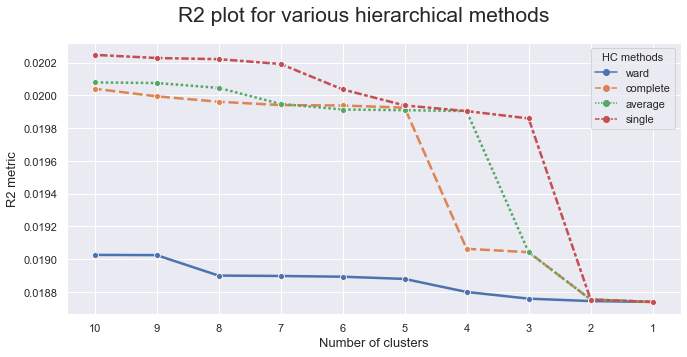

In [176]:
# Prepare input
hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df_preprocessed=df_preprocessed[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.gca().invert_xaxis()  # invert x axis
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

# Defining the number of clusters:

In [177]:
# setting distance_threshold=0 and n_clusters=None ensures we compute the full tree
linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df_preprocessed[metric_features])

array([6348, 6049, 8991, ...,    1,    2,    0], dtype=int64)

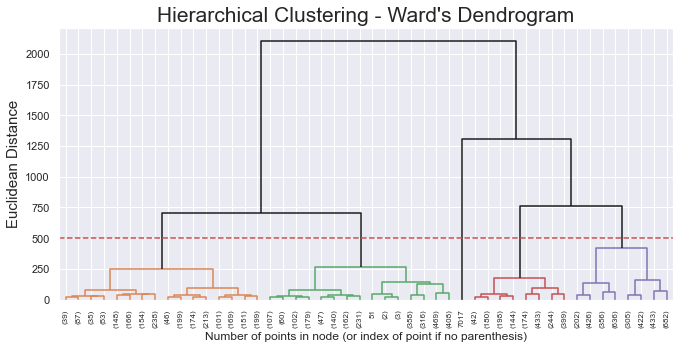

In [178]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 500
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=15)
plt.show()

# Final Hierarchical clustering solution

In [179]:
# 4 cluster solution
linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=5)
hc4_labels = hc4lust.fit_predict(df_preprocessed[metric_features])

In [180]:
# Characterizing the 4 clusters
df_concat = pd.concat((df_preprocessed, pd.Series(hc4_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD,PC0,PC1,PC2,PC3,PC4
labels,,,,,,,,,,,,,,,,,,,
0.0,0.016345,-0.003046,0.010391,-0.010438,0.006755,-0.001412,-0.016124,0.000319,0.009312,1967.414213,0.105858,0.338388,0.488255,0.067499,-0.007887,-0.015381,-0.007430,0.020189,0.008415
1.0,-0.027070,0.028282,-0.033353,0.046709,0.002243,0.001630,0.008457,-0.029972,-0.010732,1967.709486,0.116996,0.336364,0.475494,0.071146,-0.013323,0.054248,0.034733,-0.027710,0.002134
2.0,-1.085585,0.641444,0.178326,-0.186343,0.058331,-0.269329,0.569386,0.016861,-0.421881,1975.000000,0.000000,1.000000,0.000000,0.000000,-0.082536,-0.233316,0.844168,-1.104026,-0.277515
3.0,-0.007602,-0.029327,0.013106,-0.010579,-0.035749,0.011258,0.018596,0.060796,0.021246,1967.773341,0.116985,0.352081,0.464004,0.066929,0.070748,-0.015843,-0.013043,0.010722,-0.014617
4.0,0.021240,-0.016179,0.002879,-0.021018,0.005833,-0.001568,0.005186,-0.010381,-0.005987,1967.199241,0.112903,0.339658,0.472960,0.074478,-0.011004,-0.013700,-0.029765,0.000086,0.002563


# K-Means Clustering

In [181]:
df_preprocessed.columns

Index(['Salary', 'Children', 'CMV', 'Claims', 'Motor', 'Household', 'Health',
       'Life', 'Work Compensation', 'age', 'x0_1 - Basic',
       'x0_2 - High School', 'x0_3 - BSc/MSc', 'x0_4 - PhD', 'PC0', 'PC1',
       'PC2', 'PC3', 'PC4'],
      dtype='object')

In [182]:
kmclust = KMeans(n_clusters=5, init='random', n_init=1, random_state=None)
kmclust.fit(df_preprocessed[metric_features])
kmclust.predict(df_preprocessed[metric_features])

array([3, 4, 1, ..., 3, 3, 3])

In [183]:
kmclust.transform(df_preprocessed[metric_features])

array([[40.08599708, 16.64537303, 28.54355237,  4.06591874,  9.60897097],
       [53.29139569, 30.15281014, 41.81814356, 17.6571757 ,  5.09744689],
       [28.1214167 ,  5.88103865, 16.71459417,  8.7730507 , 21.37359636],
       ...,
       [34.10850624, 10.69973269, 22.57538725,  2.82969399, 15.62611514],
       [35.12133001, 12.03806139, 23.62015198,  2.63921758, 14.2569149 ],
       [39.08965749, 15.6486051 , 27.55456611,  3.38651417, 10.81328093]])

In [184]:
kmclust = KMeans(n_clusters=5, init='k-means++', n_init=15, random_state= 42)
kmclust.fit(df_preprocessed[metric_features])

KMeans(n_clusters=5, n_init=15, random_state=42)

In [185]:
kmclust.predict(df_preprocessed[metric_features])

array([0, 4, 0, ..., 0, 0, 0])

## Defining the number of Clusters:

In [186]:
range_clusters = range(1, 15)

In [187]:
inertia = []
for n_clus in range_clusters:
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state= 42)
    kmclust.fit(df_preprocessed[metric_features])
    inertia.append(kmclust.inertia_)   

In [188]:
pd.Series(inertia, index = range_clusters)

1     3.911850e+06
2     1.689650e+06
3     8.338924e+05
4     4.154621e+05
5     2.651032e+05
6     1.925941e+05
7     1.540200e+05
8     1.308885e+05
9     1.149428e+05
10    1.034003e+05
11    9.439426e+04
12    8.678954e+04
13    8.011925e+04
14    7.603363e+04
dtype: float64

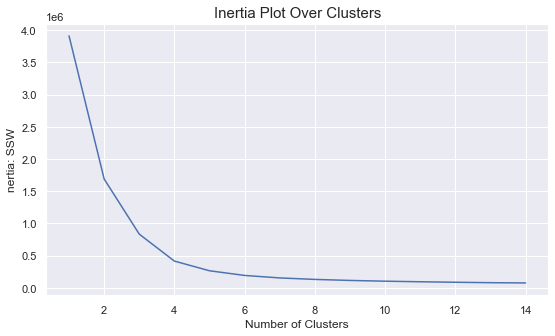

In [189]:
plt.figure(figsize=(9,5))
plt.plot(pd.Series(inertia, index = range_clusters))
plt.ylabel('nertia: SSW')
plt.xlabel('Number of Clusters')
plt.title('Inertia Plot Over Clusters', size = 15)
plt.show()

For n_clusters = 2, the average silhouette_score is : 0.5932562544627025
For n_clusters = 3, the average silhouette_score is : 0.5960440899103829
For n_clusters = 4, the average silhouette_score is : 0.5349133257129692
For n_clusters = 5, the average silhouette_score is : 0.49300805206369813
For n_clusters = 6, the average silhouette_score is : 0.4630260435157453
For n_clusters = 7, the average silhouette_score is : 0.4317594509877395
For n_clusters = 8, the average silhouette_score is : 0.3988661412529041
For n_clusters = 9, the average silhouette_score is : 0.374327417380719
For n_clusters = 10, the average silhouette_score is : 0.35777555079951745
For n_clusters = 11, the average silhouette_score is : 0.3578448516799764
For n_clusters = 12, the average silhouette_score is : 0.3335663869817979
For n_clusters = 13, the average silhouette_score is : 0.3174671353485723
For n_clusters = 14, the average silhouette_score is : 0.2946029400266018


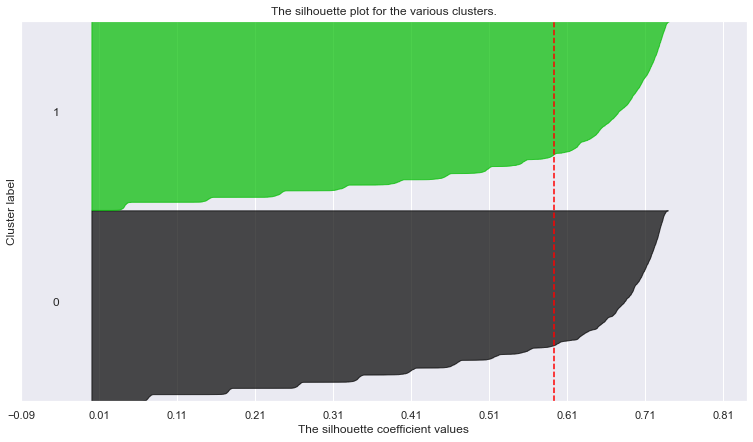

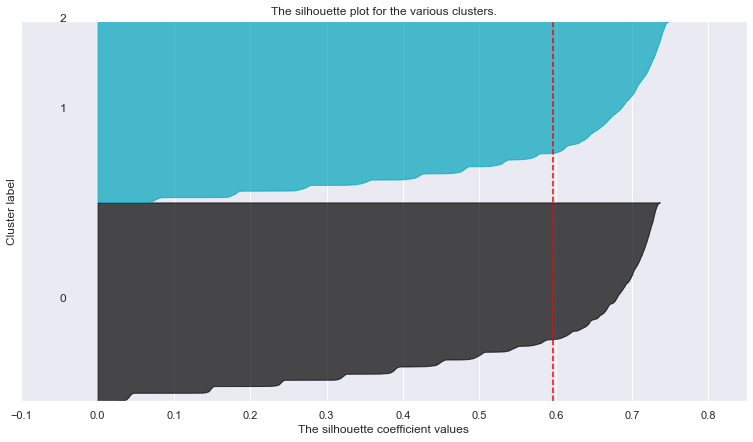

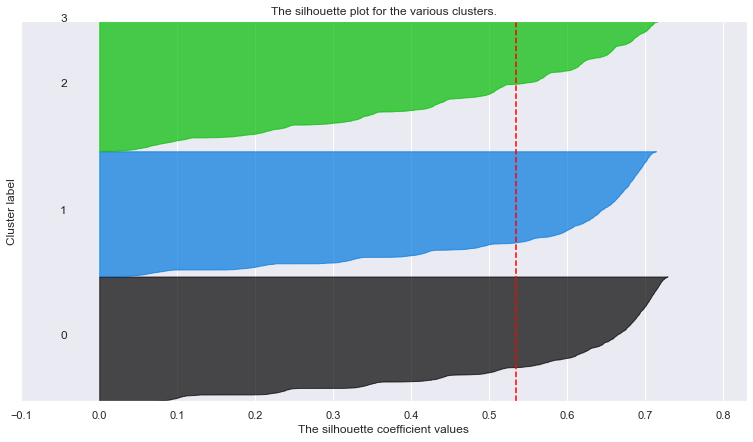

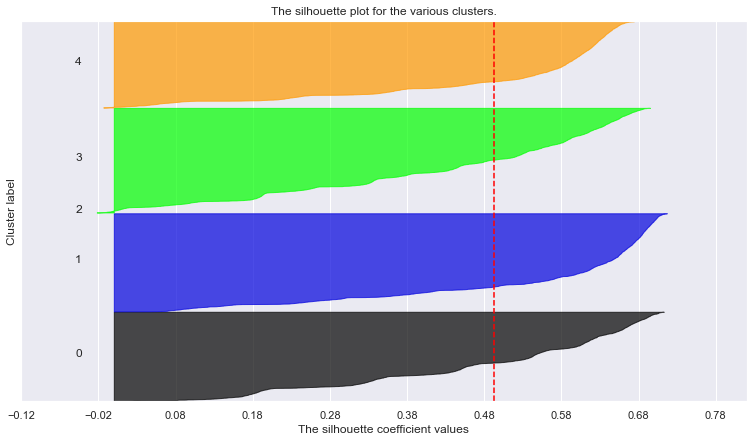

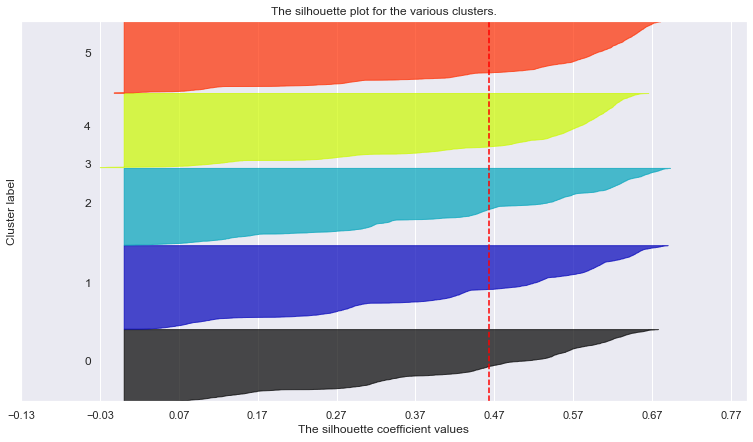

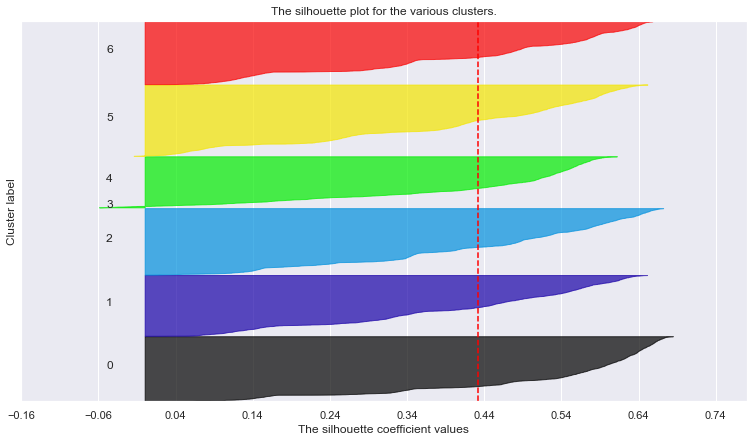

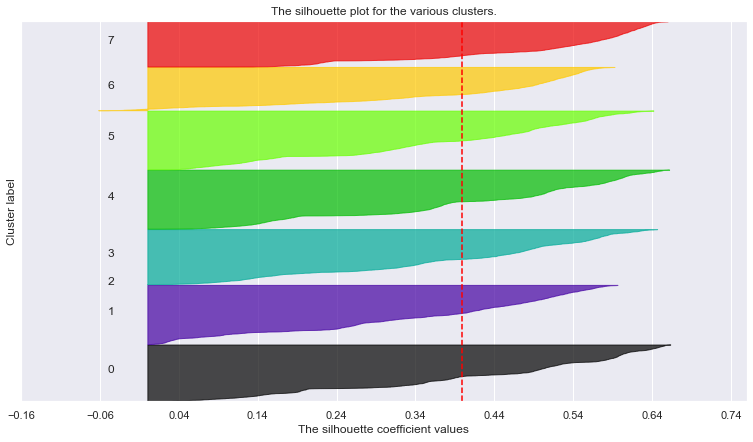

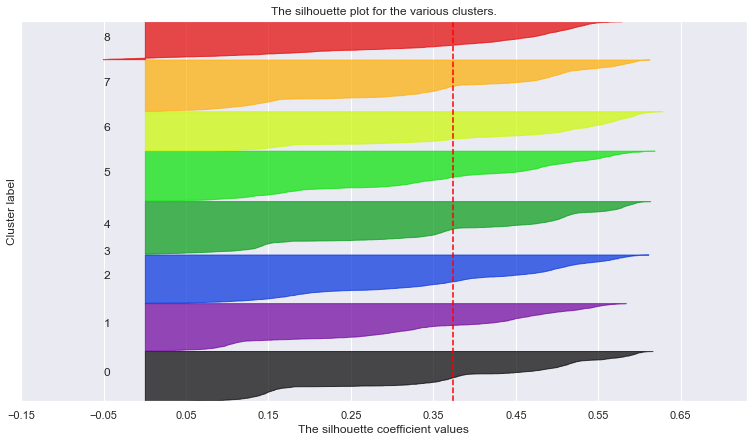

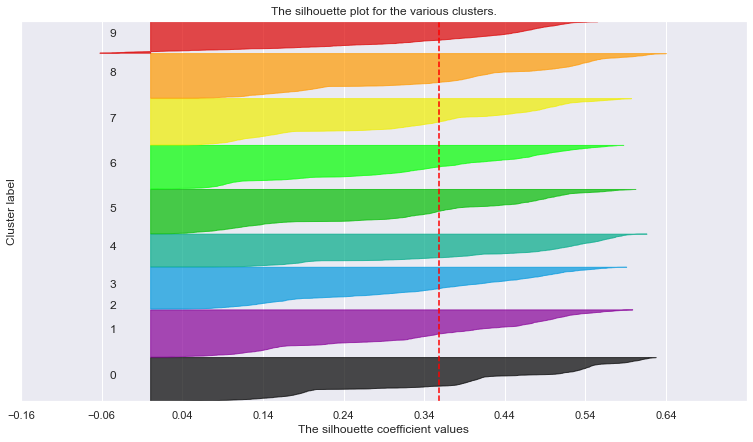

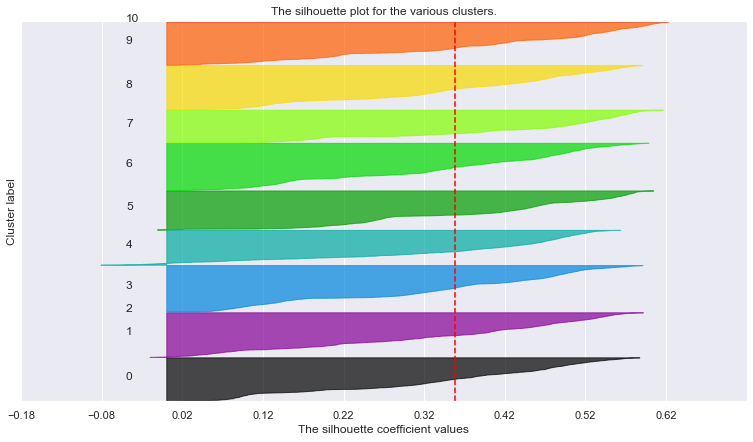

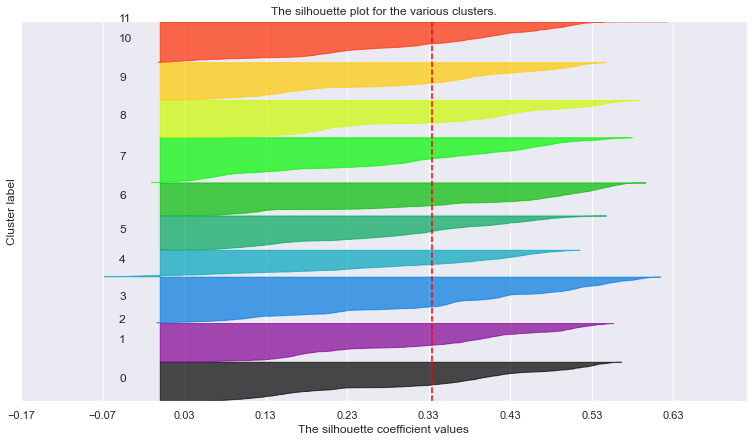

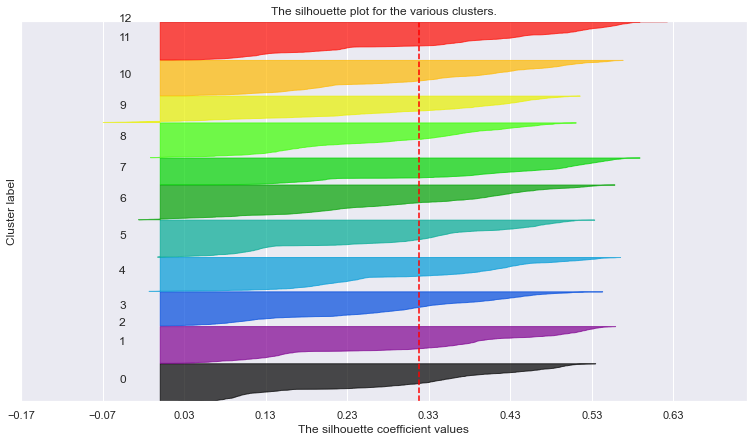

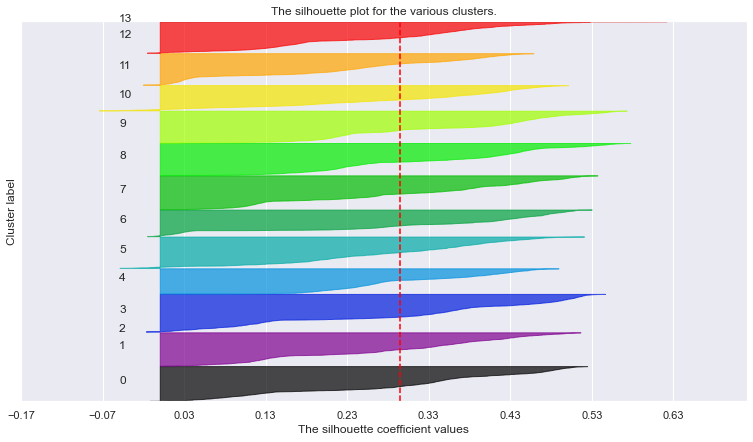

In [190]:
# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
     # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_preprocessed[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df_preprocessed[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df_preprocessed[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

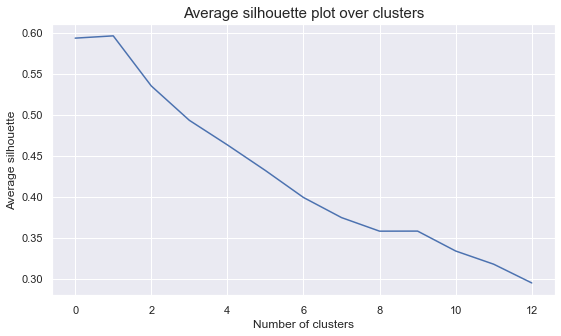

In [191]:
# The average silhouette plot
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

## Final KMeans clustering solution

In [192]:
# final cluster solution
number_clusters = 4
kmclust = KMeans(n_clusters= number_clusters, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_preprocessed[metric_features])
km_labels

array([1, 1, 2, ..., 2, 2, 1])

In [193]:
# Characterizing the final clusters
df_concat = pd.concat((df_preprocessed, pd.Series(km_labels, name='labels')), axis=1)
df_concat.groupby('labels').mean()

,Salary,Children,CMV,Claims,Motor,Household,Health,Life,Work Compensation,age,x0_1 - Basic,x0_2 - High School,x0_3 - BSc/MSc,x0_4 - PhD,PC0,PC1,PC2,PC3,PC4
labels,,,,,,,,,,,,,,,,,,,
0.0,0.008629,-0.032715,0.015598,-0.014961,-0.026600,0.003579,0.016205,0.031724,0.027360,1967.547745,0.111042,0.342768,0.478694,0.067496,0.049661,-0.018731,-0.028144,0.010289,0.007520
1.0,0.006018,-0.012202,-0.003144,-0.006181,-0.001042,-0.003793,0.007870,-0.009201,-0.003373,1967.524961,0.113488,0.339535,0.471938,0.075039,-0.003207,0.000378,-0.016523,-0.006377,0.003774
2.0,-0.008809,0.035816,-0.017992,0.026352,0.019768,0.005036,-0.019860,-0.018227,-0.014306,1967.457922,0.112309,0.339623,0.480982,0.067086,-0.032032,0.026198,0.036155,0.001355,-0.006959
3.0,-1.085585,0.641444,0.178326,-0.186343,0.058331,-0.269329,0.569386,0.016861,-0.421881,1975.000000,0.000000,1.000000,0.000000,0.000000,-0.082536,-0.233316,0.844168,-1.104026,-0.277515
